# Cod AFSC GAP Example
Focusing on the Gulf of Alaska, this example notebook for [afscgap](https://github.com/SchmidtDSE/afscgap) demonstrates a practical example for using the Python library with [zero catch record inference](https://pyafscgap.org/devdocs/afscgap.html#absence-vs-presence-data) enabled. It uses these tools to investigate a major stock decrease for Pacific cod (Gadus macrocephalus) after a warming event called "The Blob" which took place from 2014 to 2016.

**[A Samuel Pottinger](https://gleap.org)**  
**2023-03-03**  
**[UC Berkeley](https://dse.berkeley.edu/)**  

![Picture of a large ship in the Gulf of Alaska](https://pyafscgap.org/community/gulf_of_alaska_ship.jpg)

Image: [USS Theodore Roosevelt (CVN 71) transits the Gulf of Alaska after participating in Exercise Northern Edge 2019.](https://www.flickr.com/photos/56594044@N06/47951671401) by [Official U.S. Navy Imagery](https://www.flickr.com/photos/56594044@N06) is licensed under [CC BY 2.0](https://creativecommons.org/licenses/by/2.0/?ref=openverse).

<br>

## Abstract (Summary)

This notebook looks at a sharp decline in Pacific cod (Gadus macrocephalus) presence in the Gulf of Alaska before and after "The Blob" heating event. To facilitate this comparison, it looks at 2013 vs 2021. Using data from [NOAA AFSC GAP](https://www.fisheries.noaa.gov/foss/f?p=215:28), this notebook finds further confirmatory evidence of that [well documented species decline](https://www.npr.org/2019/12/08/785634169/alaska-cod-fishery-closes-and-industry-braces-for-ripple-effect) with geospatial visualizations showing areas of reduced catch during bottom trawl surveys. Furthermore, this work finds that reduced stock still persists despite the warming event having "ended" some years prior. Altogether, this notebook joins other anlysis in warning of ecological and economic threats in the area caused by climate change.

In [1]:
YEARS_AVAILABLE = [1993, 1996, 1999, 2001, 2003, 2005, 2007, 2009, 2011, 2013, 2015, 2017, 2019, 2021]

Users may consider, after running the notebook with these default parameters, trying different values and re-running to see how results change. These high level constants control aggregation, visualization, and query parameters:

In [2]:
MAX_POINT_AREA = 1000
GEOHASH_SIZE = 4
BEFORE_YEAR = 2013
AFTER_YEAR = 2021
SPECIES = 'Gadus macrocephalus'
P_THRESHOLD = 0.05

To ensure validity of these constants, some simple checks are made.

In [3]:
assert BEFORE_YEAR in YEARS_AVAILABLE
assert AFTER_YEAR in YEARS_AVAILABLE

Thanks to [Color Brewer 2](https://colorbrewer2.org/#type=sequential&scheme=BuGn&n=3) for help with these color-deficient-safe colors:

In [4]:
BEFORE_COLOR = '#33a02c80'
AFTER_COLOR = '#1f78b480'

<br>

## Background

[Gadus macrocephalus (pacific cod)](https://en.wikipedia.org/wiki/Pacific_cod) are a [particularly valuable species for fisheries](https://www.fisheries.noaa.gov/feature-story/tracking-cod-aleutian-islands). However, [their stock numbers saw a decline in the Gulf of Alaska](https://www.npr.org/2019/12/08/785634169/alaska-cod-fishery-closes-and-industry-braces-for-ripple-effect). In particular, the so called "Blob" heating event saw major temperature increases. This had major impact on the region and [prior work shows that this temperature increase may have had negative impact on spawning habitat](https://cdnsciencepub.com/doi/full/10.1139/cjfas-2019-0238). Regardless, this event ultimately caused the federal cod fishery to close for the 2020 season with concerns that continued climate change will further stress the species in the future. For more information, see a [related blog series from Ben Laurel at NOAA Fisheries](https://www.fisheries.noaa.gov/science-blog/young-fish-provide-clues-future-pacific-cod-stock-size-post-1).

![Picture of Pacific Cod](https://pyafscgap.org/community/cod_image_noaa_public.jpg)

[Pacific Cod](https://www.fisheries.noaa.gov/species/pacific-cod) by NOAA under [public domain](https://www.fisheries.noaa.gov/national/about-us/website-policies-and-disclaimers).

The later parts of this notebook provide a more rigerous analysis but investigation can simply start by looking at the number of cod specimen found before and after the blob in the Gulf of Alaska

In [5]:
import afscgap

In [6]:
query_before = afscgap.query(
    srvy='GOA',
    year=BEFORE_YEAR,
    scientific_name=SPECIES
)

query_after = afscgap.query(
    srvy='GOA',
    year=AFTER_YEAR,
    scientific_name=SPECIES
)

In [7]:
count_before = sum(map(lambda x: x.get_count(), query_before))
count_after = sum(map(lambda x: x.get_count(), query_after))

In [8]:
template_vals = (count_before, BEFORE_YEAR, count_after, AFTER_YEAR)
template = '%.0f specimen found in %d and %.0f specimen found in %d'
print(template % template_vals)

16972 specimen found in 2013 and 4013 specimen found in 2021


<br>

## Method

While the overall count provides an interesting starting point, each year's survey may not look at exactly the same areas or with the exact same equipment. Therefore, this notebook demonstrates use of [afscgap](https://github.com/SchmidtDSE/afscgap) by plotting [Gadus macrocephalus (pacific cod)](https://en.wikipedia.org/wiki/Pacific_cod) in the Gulf of Alaska after normalizing weight by area swept. It leverages a modern stack:

 - [geolib](https://pypi.org/project/geolib/) to aggregate by [geohash](https://en.wikipedia.org/wiki/Geohash)
 - Plots via [Cartopy](https://pypi.org/project/Cartopy/) and [Matplotlib](https://matplotlib.org/).
 - Manipulation via [Pandas](https://pandas.pydata.org/).
 - Statistical test by [scipy.stats](https://docs.scipy.org/doc/scipy/reference/stats.html).

It does this to show how to work with these data, both in a memory efficient way prior to aggregation by geohash where the dataset is quite large and after when the data fit into a more "typical" data frame. Specifically, weight and area swept are aggregated by geohash to get a map of overall catch weight per unit effort across the Gulf of Alaska before plotting some summary statistics and executing a statistical test.

In [9]:
import copy
import math

import cartopy.crs
import geolib.geohash
import matplotlib.pyplot
import pandas
import scipy.stats

#### Query

This notebook starts by making a method to execute a query for a given year. Note that this uses `presence_only=False`. This enables [zero catch record inference](https://pyafscgap.org/devdocs/afscgap.html#absence-vs-presence-data) and is necessary in this case becuase the official API service will get "presence-only" data that, while much more compact, can't report on hauls when the species of interest was not found.

In [10]:
def make_query(year):
    query = afscgap.query(
        srvy='GOA',
        year=year,
        scientific_name=SPECIES,
        presence_only=False,
        suppress_large_warning=True
    )
    complete_results = filter(lambda x: x.is_complete(), query)
    simplified_results = map(simplify_record, complete_results)
    aggregated_results = aggregate_geohashes(simplified_results)
    return aggregated_results

To understand the need for this feature consider, that this notebook aims to, per geohash, get total weight of species of interest divided by total area swept. However, notice that it must include area swept for all hauls in an area. The official NOAA AFSC GAP API on its own [does not yield records for a species in a haul if no specimens of that species were found](https://www.fisheries.noaa.gov/foss/f?p=215:28). Therefore, it requires that the `afscgap` library infer hauls without the species of interest found. It does this by comparing results from the official API service to a metadata record of all hauls conducted.

#### Aggregation and simplification

This noteboook simplifies the Record objects returned by afscgap, taking a small subset of their data and putting them into dictionaries as they are returned from the library along with a geohash.

In [11]:
def simplify_record(full_record):
    latitude = full_record.get_latitude_dd()
    
    longitude = full_record.get_longitude_dd()
    if longitude > 0:
        longitude = longitude * -1
    
    return {
        'geohash': geolib.geohash.encode(latitude, longitude, GEOHASH_SIZE),
        'area': full_record.get_area_swept_ha(),
        'weight': full_record.get_weight_kg()
    }

This notebook aggregates data, collecting into a dictionary. This reduces memory load because information is streamed in but, instead of maintaining individual records per haul, summarizes those data by geohash as they become available. This avoids loading the entire dataset in memory.

In [12]:
def aggregate_geohashes(results):
    results_agg = {}
    
    for result in results:
        geohash = result['geohash']
        
        if geohash not in results_agg:
            results_agg[geohash] = {
                'geohash': geohash,
                'area': 0,
                'weight': 0
            }
        
        results_agg[geohash]['area'] += result['area']
        results_agg[geohash]['weight'] += result['weight']
    
    return results_agg.values()

#### Calculate weight per area

Next, the notebook needs to calculate weight per area swept.

In [13]:
def summarize_data(target):
    point = geolib.geohash.decode(target['geohash'])
    
    target_copy = copy.deepcopy(target)
    target_copy['latitude'] = point[0]
    target_copy['longitude'] = point[1]
    target_copy['weightPerArea'] = target_copy['weight'] / target['area']
    
    return target_copy

#### Execute statistical test

Finally, the notebook looks for geohashes with hauls in both surveys to conduct a [Wilcoxon signed-rank test](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.wilcoxon.html).

In [14]:
def execute_test(before_data, after_data):
    before_data_by_geohash = dict(map(lambda x: (x['geohash'], x), before_data))
    after_data_by_geohash = dict(map(lambda x: (x['geohash'], x), after_data))
    
    before_geohashes = set(before_data_by_geohash.keys())
    after_geohashes = set(after_data_by_geohash.keys())
    overlap_geohashes = sorted(before_geohashes.intersection(after_geohashes))
    
    before_weights_by_area = [
        before_data_by_geohash[geohash]['weightPerArea'] for geohash in overlap_geohashes
    ]
    after_weights_by_area = [
        after_data_by_geohash[geohash]['weightPerArea'] for geohash in overlap_geohashes
    ]
    
    results = scipy.stats.wilcoxon(
        before_weights_by_area,
        after_weights_by_area
    )
    
    return {'p': results[1], 'statistic': results[0]}

<br>

## Results

This notebook next downloads data from the two years selected and summarizes using the utility functions.

In [15]:
raw_data_by_geohash_before = make_query(BEFORE_YEAR)
summarized_data_before = [summarize_data(record) for record in raw_data_by_geohash_before]
frame_before = pandas.DataFrame(summarized_data_before)

In [16]:
raw_data_by_geohash_after = make_query(AFTER_YEAR)
summarized_data_after = [summarize_data(record) for record in raw_data_by_geohash_after]
frame_after = pandas.DataFrame(summarized_data_after)

#### Get totals

An easy first step is simply displaying how the overall numbers from the Gulf of Alaska surveyed changed between years adjusting for area swept.

In [17]:
before_weight_per_hectare = frame_before['weight'].sum() / frame_before['area'].sum()
print('Kilograms of %s / hectare from %d: %.2f' %(SPECIES, BEFORE_YEAR, before_weight_per_hectare))

Kilograms of Gadus macrocephalus / hectare from 2013: 19.77


In [18]:
after_weight_per_hectare = frame_after['weight'].sum() / frame_after['area'].sum()
print('Kilograms of %s / hectare from %d: %.2f' %(SPECIES, AFTER_YEAR, after_weight_per_hectare))

Kilograms of Gadus macrocephalus / hectare from 2021: 5.88


Source of data: AFSC GAP


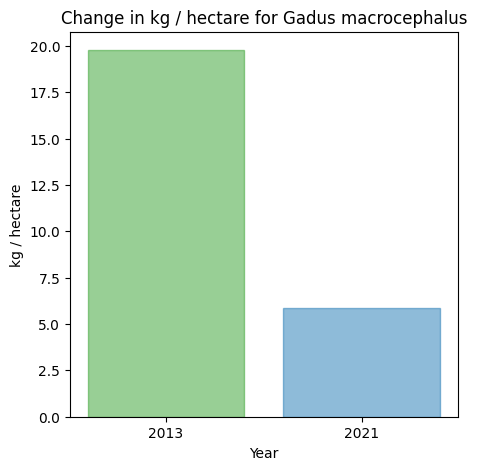

In [19]:
fig = matplotlib.pyplot.figure(figsize=(5,5))
ax = fig.add_subplot(111)
bars = ax.bar([str(BEFORE_YEAR), str(AFTER_YEAR)], [before_weight_per_hectare, after_weight_per_hectare])
bars[0].set_color(BEFORE_COLOR)
bars[1].set_color(AFTER_COLOR)
ax.set_title('Change in kg / hectare for %s' % SPECIES)
ax.set_xlabel('Year')
ax.set_ylabel('kg / hectare')

print('Source of data: AFSC GAP')

#### Histogram of geohash weight / area swept

Next, the notebook can visualize how the distribution of weights / area in terms of geohashes examined differs per year. For convienence, this notebook filters out geohashes with zero catches.

In [20]:
max_value = max([frame_after['weightPerArea'].max(), frame_before['weightPerArea'].max()])

Source of data: AFSC GAP


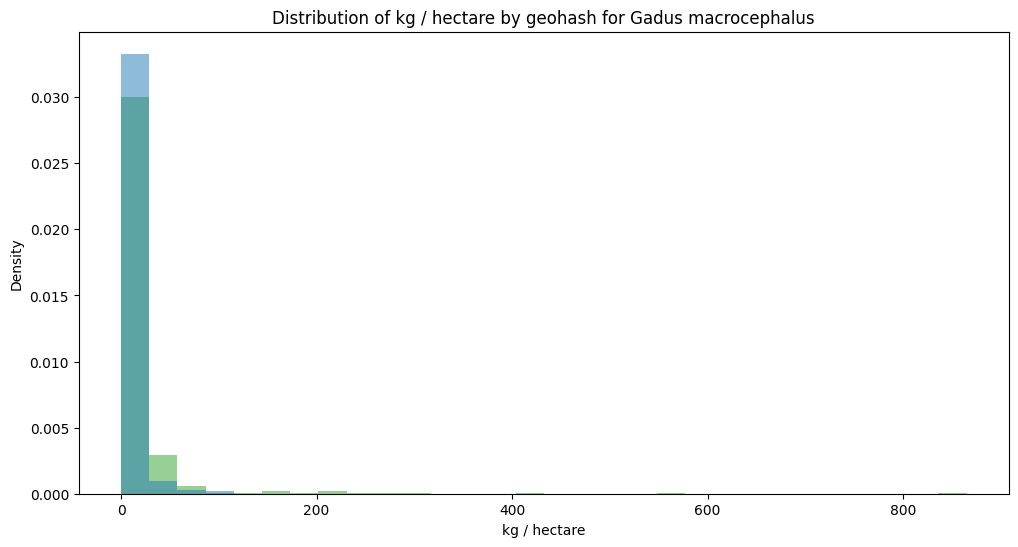

In [21]:
fig = matplotlib.pyplot.figure(figsize=(12,6))
ax = fig.add_subplot(111)
ax.hist(frame_before['weightPerArea'], 30, range=[0, max_value], color=BEFORE_COLOR, density=True)
ax.hist(frame_after['weightPerArea'], 30, range=[0, max_value], color=AFTER_COLOR, density=True)
ax.set_title('Distribution of kg / hectare by geohash for %s' % SPECIES)
ax.set_xlabel('kg / hectare')
ax.set_ylabel('Density')

print('Source of data: AFSC GAP')

#### Scaffolding for geographic visualizations

This notebook next turns to visualize the weights / area swept but, to facilitate, will calculate the area of dots in a bubble / scatter plot using a scale shared across both years.

In [22]:
def scale_value(target):
    return (target / max_value) * MAX_POINT_AREA

In [23]:
frame_before['pointArea'] = frame_before['weightPerArea'].apply(scale_value)
frame_after['pointArea'] = frame_after['weightPerArea'].apply(scale_value)

#### Geographic distribution in before year

Starting with the earlier "before" year, this notebook uses the calculations from before to plot them on a map.

Source of data: AFSC GAP


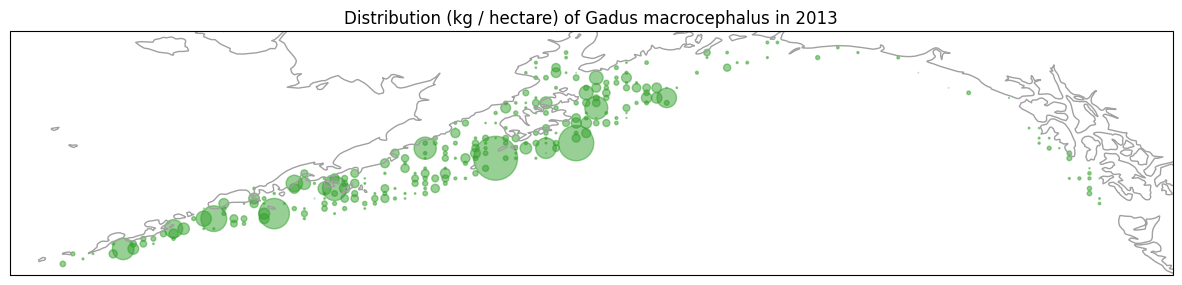

In [24]:
fig = matplotlib.pyplot.figure(figsize=(15,15))
ax = matplotlib.pyplot.axes(projection=cartopy.crs.PlateCarree())
ax.coastlines(resolution='50m', color='#A0A0A0', linewidth=1)

ax.scatter(
    frame_before['longitude'],
    frame_before['latitude'],
    label=str(BEFORE_YEAR),
    s=frame_before['pointArea'],
    c='#33a02c',
    alpha=0.5
)
ax.set_title('Distribution (kg / hectare) of %s in %d' % (SPECIES, BEFORE_YEAR))

print('Source of data: AFSC GAP')

#### Geographic distribution in before year

Next, the notebook does the same with the later "after" year.

Source of data: AFSC GAP


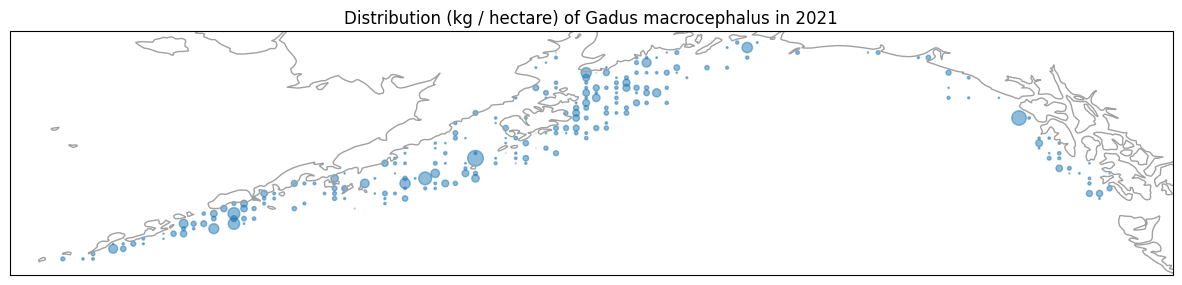

In [25]:
fig = matplotlib.pyplot.figure(figsize=(15,15))
ax = matplotlib.pyplot.axes(projection=cartopy.crs.PlateCarree())
ax.coastlines(resolution='50m', color='#A0A0A0', linewidth=1)

ax.scatter(
    frame_after['longitude'],
    frame_after['latitude'],
    label=str(AFTER_YEAR),
    s=frame_after['pointArea'],
    c='#1f78b4',
    alpha=0.5
)

ax.set_title('Distribution (kg / hectare) of %s in %d' % (SPECIES, AFTER_YEAR))

print('Source of data: AFSC GAP')

#### Geographic distribution in before year

Next, the notebook overlays the two years for easier comparison.

Source of data: AFSC GAP


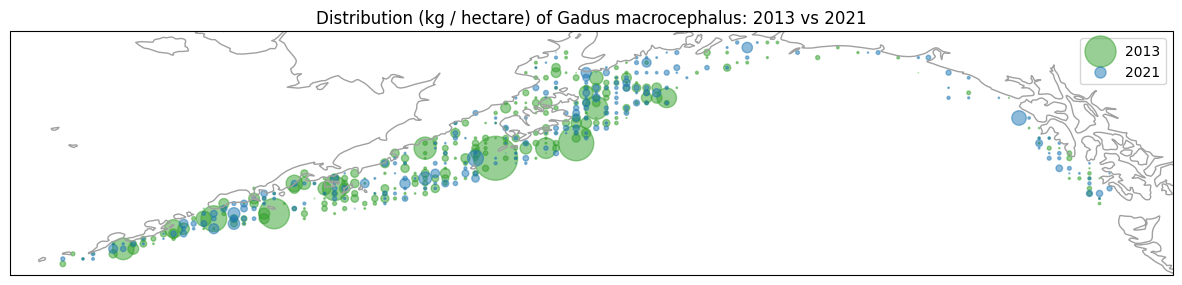

In [26]:
fig = matplotlib.pyplot.figure(figsize=(15,15))
ax = matplotlib.pyplot.axes(projection=cartopy.crs.PlateCarree())
ax.coastlines(resolution='50m', color='#A0A0A0', linewidth=1)

ax.scatter(
    frame_before['longitude'],
    frame_before['latitude'],
    label=str(BEFORE_YEAR),
    s=frame_before['pointArea'],
    c='#33a02c',
    alpha=0.5
)
ax.scatter(
    frame_after['longitude'],
    frame_after['latitude'],
    label=str(AFTER_YEAR),
    s=frame_after['pointArea'],
    c='#1f78b4',
    alpha=0.5
)

ax.legend()

ax.set_title('Distribution (kg / hectare) of %s: %d vs %d' % (SPECIES, BEFORE_YEAR, AFTER_YEAR))

print('Source of data: AFSC GAP')

#### Statistical test

Next, this notebook evaluates if the change is statistically significant for overlapping geohashes.

In [27]:
test_results = execute_test(summarized_data_before, summarized_data_after)

In [28]:
template_vals = (BEFORE_YEAR, AFTER_YEAR, SPECIES, P_THRESHOLD)

if test_results['p'] < 0.05:
    template = 'Geohashes observed in %d saw significantly different kg / hectare than %d for %s (p < %.2f).'
else:
    template = 'Geohashes observed in %d not significantly different kg / hectare than %d for %s (p >= %.2f).'

message = template % template_vals
print(message)

Geohashes observed in 2013 saw significantly different kg / hectare than 2021 for Gadus macrocephalus (p < 0.05).


<br>

## Discussion

This notebook observes a sizable drop in weight normalized by area swept for Pacific cod when comparing 2013 to 2021. Notably, this observes low presence some time after "The Blob" warming event, possibly suggesting that the impacts of similar events may last even after the warming itself subsides. Of course, these data are not perfect. It's possible that the same species shifted geographically outside the surveyed area or some other difference between the surveys exists to cause lower reporting. However, in combination with [research on mechanistic understanding of Pacific cod reductions due to warming](https://cdnsciencepub.com/doi/full/10.1139/cjfas-2019-0238), the case for warming itself explaining these findings remains strong. Given their importance to human communities along with continued climate change, these results may suggest that a mechanism may exist for similar warming events in the region to inflict not just further ecological but also economic harm to the region.

<br>

## Conclusion

This notebook provides an example use of the [afscgap Python library](https://github.com/SchmidtDSE/afscgap) to conduct analysis / visualization of important biological data as demonstrated by examination of Pacific cod (Gadus macrocephalus) declines in the Gulf of Alaska. Though some confounders may still exist, these data confirm prior work and further emphasize the ecological and economic risk posed by warming in the region. Analysis highlights that threats to the human food system continue to persist in the area with plausible links to climate change.